**Machine Learning and Wi-Fi:
Confluences, Ongoing Activities, and Ways Forward**

*Hands-on exercise: Implementation of a Deep Learning model for predicting the performance of IEEE 802.11ax WLANs*

Authors: Francesc Wilhelmi, Szymon Szott, Katarzyna Kosek-Szott, Boris Bellalta


October, 2023
MobiCom

---

We are going to train and evaluate a deep learning model to fulfill a regression task on the performance of IEEE 802.11ax Spatial Reuse (SR) networks.

The dataset used in this exercise contains simulated traces of multiple random IEEE 802.11ax WLAN deployments and it was part of the 2021 Edition of the ITU AI for Communications Challenge*. Further details about the original problem statement can be found here: https://challenge.aiforgood.itu.int/match/matchitem/37.

*Wilhelmi, Francesc, et al. "Federated spatial reuse optimization in next-generation decentralized IEEE 802.11 WLANs." ITU Journal on Future and Evolving Technologies, Volume 3 (2022), Issue 2, Pages 117-133. [Available here](https://www.itu.int/en/publications/gs/pages/publications.aspx?parent=S-JNL-VOL3.ISSUE2-2022-A11&media=electronic).

---

**STEP 0:** Import all the necessary packages.

In this hands-on, we will use [TensorFlow](https://www.tensorflow.org/), but other frameworks such as [PyTorch](https://pytorch.org/) and [Keras](https://keras.io/) are also nice to explore.

---

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn import preprocessing
from google.colab import files

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

---

**STEP 1:** Load the training and  evaluation (test) datasets from files available at public URLs.

The provided dataset is already pre-processed by:
*   Providing the data in Table format (loaded as a `DataFrame`)
*   Removing unnecessary information
*   Removing NaN/Inf values from the raw data

The set of available features are as follows:


1.   **'context':** Label referring to the type of deployment. Used for the purpose of training a federated learning model within the original ITU AI Challenge. **The context can be ignored in this exercise.**
2.   **'obss_pd':** OBSS/PD threshold used within the IEEE 802.11ax SR operation. More details here: Wilhelmi, F., Barrachina-Muñoz, S., Cano, C., Selinis, I., & Bellalta, B. (2021). Spatial reuse in IEEE 802.11 ax WLANs. Computer Communications, 170, 65-83. [Online version](https://arxiv.org/pdf/1907.04141.pdf)
3.   **'throughput':** Average throughput obtained by all BSSs in the sceneario.
4.   **'interference':** Average interference sensed by the devices from other APs in the OBSS.
5.   **'rssi':** Average received signal strenth indicator (RSSI) sensed by the devices in the OBSS.
6.   **'sinr':** Average signal to interference plus noise ratio (SINR) experienced by the devices in the OBSS.

**DISCLAIMER: The data used in this exercise has been simplified for demonstration purposes. For instance, instead of providing the throughput obtained by each device, we provide the average throughput across all the devices. Similarly, interference, RSSI, and SINR metrics are compacted. The original dataset can be found at https://zenodo.org/record/5656866**

---

In [2]:
# Load the training dataset (e.g., Sce2)
url='https://drive.google.com/file/d/1WdGxw3Oqm-pycQWpr1BjHN6oJ6pwd2Rb/view?usp=sharing'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
train_data_set = pd.read_csv(dwn_url, names=['context', 'obss_pd', 'throughput', 'interference', 'rssi', 'sinr'], sep=";", skiprows=1)
print('Training dataset')
print(train_data_set.head())

# Load the evaluation (test) dataset
url='https://drive.google.com/file/d/1BazG82OTa8wd10bIqVbduzaIf_FiOO0q/view?usp=sharing'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
eval_data_set = pd.read_csv(dwn_url, names=['context', 'obss_pd', 'throughput', 'interference', 'rssi', 'sinr'], sep=";", skiprows=1)
print('Evaluation dataset')
print(eval_data_set.head())

Training dataset
   context   obss_pd  throughput  interference      rssi      sinr
1   3000.0  1.016129       5.670       1.97508  2.493500  1.166833
2   3000.0  1.032258      11.280       1.97508  1.893500  0.806500
3   3000.0  1.048387       7.520       1.97508  2.426833  0.792500
4   3000.0  1.064516      13.085       1.97508  2.393500  1.123167
5   3000.0  1.080645      14.350       1.97508  2.360167  1.110000
Evaluation dataset
   context   obss_pd  throughput  interference      rssi      sinr
1      1.0  1.241935         0.0      1.941050  1.809833  1.253667
2      2.0  1.322581         0.0      1.642200  1.804500  1.324000
3      3.0  1.177419         0.0      2.008080  1.936833  0.986333
4      4.0  1.129032         0.0      1.590267  1.877917  1.277833
5      5.0  1.225806         0.0      1.799650  1.758583  1.390083


---

**STEP 2:** Understanding the data

* The *info()* method provides basic information about the `DataFrame`.
* The mean and std values for each feature are printed.
* The histogram of each feature is plotted for each dataset partition.
* The correlation among the features is plotted for each dataset partition.

Note that the prediction label in the test dataset is not available at this step.

---

Training dataset info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20999 entries, 1 to 20999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   context       20999 non-null  float64
 1   obss_pd       20999 non-null  float64
 2   throughput    20999 non-null  float64
 3   interference  20999 non-null  float64
 4   rssi          20999 non-null  float64
 5   sinr          20999 non-null  float64
dtypes: float64(6)
memory usage: 1.1 MB
None

Training dataset mean values
context         3499.523787
obss_pd            1.161298
throughput        17.152897
interference       1.769651
rssi               1.947502
sinr               1.026599
dtype: float64

Training dataset standard deviation values
context         288.668157
obss_pd           0.097664
throughput       11.192547
interference      0.379604
rssi              0.195414
sinr              0.339025
dtype: float64


Evaluation dataset mean values
context       

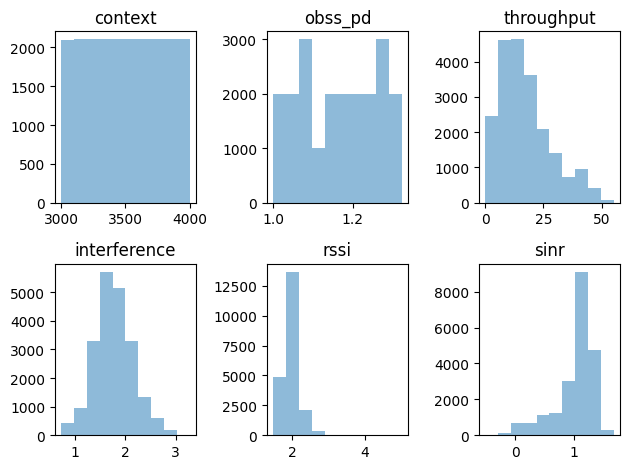

  -  Features correlations (training dataset):


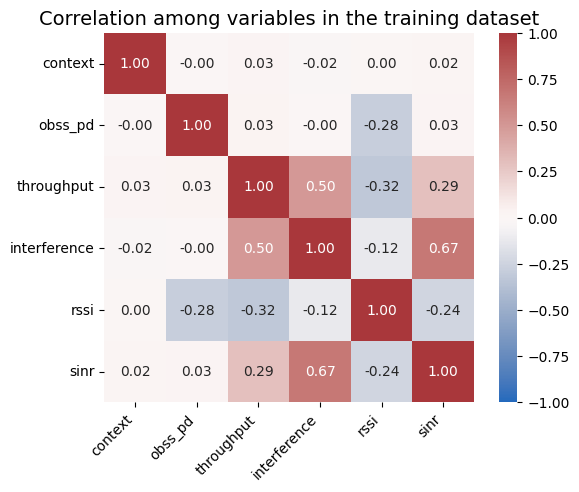

Test dataset plots:
  -  Histogram (test dataset):


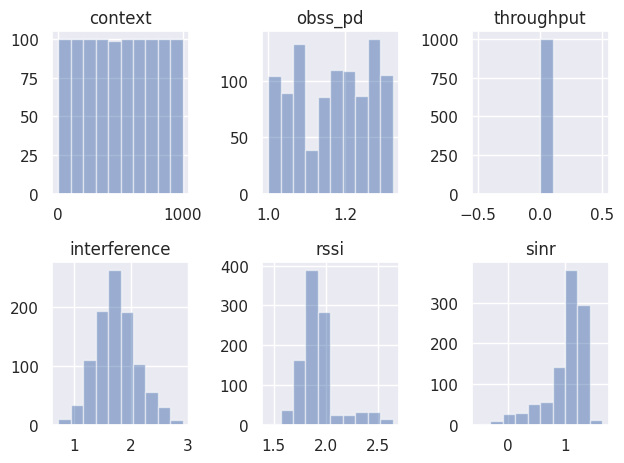

  -  Features correlations (test dataset):


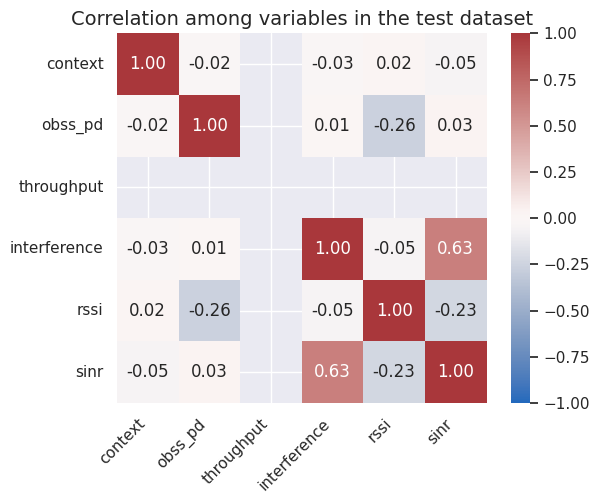

In [3]:
print('Training dataset info')
print(train_data_set.info())

print('')
print('Training dataset mean values')
print(train_data_set.mean(axis=0))

print('')
print('Training dataset standard deviation values')
print(train_data_set.std(axis=0))
print('')

print('')
print('Evaluation dataset mean values')
print(eval_data_set.mean(axis=0))

print('')
print('Evaluation dataset standard deviation values')
print(eval_data_set.std(axis=0))

print('Training dataset plots:')
# Plot a histogram of the values of each feature in the training dataset
print('  -  Histogram (training dataset):')
fig = plt.figure()
i = 0
for feature in train_data_set:
    plt.subplot(2, 3, i + 1)
    plt.title(feature)
    plt.hist(train_data_set.get(feature), alpha=0.5)
    i = i + 1
fig.tight_layout()
plt.show()

# Plot correlations among variables in the training dataset
print('  -  Features correlations (training dataset):')
plt.figure()
corr = train_data_set.corr()
ax = sns.heatmap(corr, annot=True, vmin=-1.0, vmax=1.0, cbar=True, square=True, fmt=".2f", cmap='vlag')
sns.set(font_scale=1)
ax.set_xticklabels(train_data_set.columns, rotation=45, horizontalalignment='right')
ax.set_yticklabels(train_data_set.columns, rotation=0, horizontalalignment='right')
plt.title('Correlation among variables in the training dataset', fontsize=14)
plt.show()

print('Test dataset plots:')
# Plot a histogram of the values of each feature in the training dataset
print('  -  Histogram (test dataset):')
fig = plt.figure()
i = 0
for feature in eval_data_set:
    plt.subplot(2, 3, i + 1)
    plt.title(feature)
    plt.hist(eval_data_set.get(feature), alpha=0.5)
    i = i + 1
fig.tight_layout()
plt.show()

# Plot correlations among variables in the test dataset
print('  -  Features correlations (test dataset):')
plt.figure()
corr = eval_data_set.corr()
ax = sns.heatmap(corr, annot=True, vmin=-1.0, vmax=1.0, cbar=True, square=True, fmt=".2f", cmap='vlag')
sns.set(font_scale=1)
ax.set_xticklabels(eval_data_set.columns, rotation=45, horizontalalignment='right')
ax.set_yticklabels(eval_data_set.columns, rotation=0, horizontalalignment='right')
plt.title('Correlation among variables in the test dataset', fontsize=14)
plt.show()

---

**STEP 3:** Prepare the dataset to be fed to the ML model:


*   Separate features from labels
*   In the centralized case, remove the context information
*   Convert `DataFrame` data into a numpy array

---

In [4]:
# Copy the dataframe to manipulate it
train_features = train_data_set.copy()
# Remove the "context" for the centralized solution
train_features.pop('context')
# Separate features from labels
train_labels = train_features.pop('throughput')

# Convert the features and labels into arrays
train_features = np.array(train_features)
print('Features ')
print(train_features[0]) # Print only the first value

train_labels = np.array(train_labels)
print('Labels ')
print(train_labels[0]) # Print only the first value

# Normalize the features and labels using a standard scaler
scaler = preprocessing.StandardScaler()
#x_train = scaler.fit_transform(train_features)
x_train = train_features
print('Normalized Features (training) ')
print(x_train[0]) # Print only the first value
#y_train = scaler.fit_transform(train_labels.reshape(-1, 1))
y_train = train_labels
print('Normalized Labels (training) ')
print(y_train[0]) # Print only the first value

Features 
[1.01612903 1.97508    2.4935     1.16683333]
Labels 
5.67
Normalized Features (training) 
[1.01612903 1.97508    2.4935     1.16683333]
Normalized Labels (training) 
5.67


In [5]:
# Do the same for the eval. (test) dataset

# Copy the dataframe to manipulate it
eval_features = eval_data_set.copy()
# Remove the "context" for the centralized solution
eval_features.pop('context')
# Separate features from labels
eval_labels = eval_features.pop('throughput')

# Convert the evaluation features and labels to arrays
eval_features = np.array(eval_features)
print('Features ')
print(eval_features [0]) # Print only the first value

eval_labels = np.array(eval_labels)
print('Labels ')
print(eval_labels[0]) # Print only the first value

# Normalize the evaluation features and labels
#x_eval = scaler.fit_transform(eval_features)
x_eval = eval_features
print('Normalized Features (evaluation)')
print(x_eval[0]) # Print only the first value
#y_eval = scaler.fit_transform(eval_labels.reshape(-1, 1))
y_eval = eval_labels
print('Normalized Labels (evaluation)')
print(y_eval[0]) # Print only the first value

Features 
[1.24193548 1.94105    1.80983333 1.25366667]
Labels 
0.0
Normalized Features (evaluation)
[1.24193548 1.94105    1.80983333 1.25366667]
Normalized Labels (evaluation)
0.0


---

**STEP 4:** Define and compile the ML model to be trained.

*STEP 4.1: Model definition*
*   In this case, we use a Feed-Forward Neural Network (FFNN) with 3 hidden layers containing 512, 256, and 128 neurons each.
*   To instantiate the NN, we use the `tf.keras.Sequential()` method.
*   ReLU is used as an activation function. Other functions are available [here](https://keras.io/api/layers/activations/).
*   A final dropout is applied to reduce overfitting effects. The dropout is a regularization technique whereby weigths from a NN are removed with probability *p* (in this case, p=0.1). More information on dropout layers can be found [here](https://keras.io/api/layers/regularization_layers/dropout/).


*STEP 4.2: Model compilation*
*   The model is configured for training through the `compile()` method.
*   To train the model, we use MSE as loss metric. More information on loss metrics can be found [here](https://keras.io/api/metrics/).
*   The ADAM optimizer* is used to update the model weights in each epoch. Other optimizers can be found [here](https://keras.io/api/optimizers/).
*   We keep track of the training performance in terms of MSE, MAE, and MAPE.

*Kingma, D. P., & Ba, J. (2014). Adam: A method for stochastic optimization. [arXiv preprint arXiv:1412.6980](https://arxiv.org/pdf/1412.6980.pdf).

---

In [6]:
# Define the ML model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(512, input_shape=(4,)))
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(1))

# Compile the model and assign losses and optimizer
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['mse', 'mae', 'mape'])

---

**STEP 5:** Train the ML model on the training dataset

We now use the training dataset (`x_train` and `y_train`) to train the model through the `fit()` method.

---

In [ ]:
# Train the model with the dataset
print("Train the model:")
history = model.fit(x_train, y_train, epochs=200, verbose=1, batch_size=32)

Train the model:
Epoch 1/200
657/657 [==============================] - 4s 5ms/step - loss: 97.5282 - mse: 97.5282 - mae: 7.5187 - mape: 160.3267
Epoch 2/200
657/657 [==============================] - 3s 5ms/step - loss: 86.5122 - mse: 86.5122 - mae: 7.0515 - mape: 145.2230
Epoch 3/200
657/657 [==============================] - 4s 6ms/step - loss: 83.7077 - mse: 83.7077 - mae: 6.9501 - mape: 141.9606
Epoch 4/200
657/657 [==============================] - 3s 5ms/step - loss: 82.5695 - mse: 82.5695 - mae: 6.8922 - mape: 140.1300
Epoch 5/200
657/657 [==============================] - 3s 5ms/step - loss: 81.4939 - mse: 81.4939 - mae: 6.8506 - mape: 137.7322
Epoch 6/200
657/657 [==============================] - 4s 6ms/step - loss: 80.4226 - mse: 80.4226 - mae: 6.8046 - mape: 137.5219
Epoch 7/200
657/657 [==============================] - 4s 5ms/step - loss: 79.9905 - mse: 79.9905 - mae: 6.7897 - mape: 136.2790
Epoch 8/200
657/657 [==============================] - 3s 5ms/step - loss: 79.31

In [ ]:
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss=mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

---

**STEP 6:** Evaluate the ML model on the test dataset

---

In [ ]:
# Evaluate the model on the test dataset using `evaluate`
print("Evaluate on test data:")
url='https://drive.google.com/file/d/1UxR--7r_UNtsJAJp4elk65_jMEV68HAy/view?usp=sharing'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
test_data_set = pd.read_csv(dwn_url, names=['context', 'obss_pd', 'throughput', 'interference', 'rssi', 'sinr'], sep=";", skiprows=1)
# Copy the dataframe to manipulate it
test_features = test_data_set.copy()
# Remove the "context" for the centralized solution
test_features.pop('context')
# Separate features from labels
test_labels = test_features.pop('throughput')

# Convert the evaluation features and labels to arrays
test_features = np.array(test_features)
print('Features ')
print(test_features[0:3])

test_labels = np.array(test_labels)
print('Labels ')
print(test_labels[0:3])

# Normalize the evaluation features and labels
#x_test = scaler.fit_transform(test_features)
x_test = test_features
print('Normalized Features (test)')
print(x_test[0:3])
#y_test = scaler.fit_transform(test_labels.reshape(-1, 1))
y_test = test_labels
print('Normalized Labels (test)')
print(y_test[0:3])

# Evaluate the trained model on the test data
test_metrics = model.evaluate(x_test, y_test)
print(test_metrics)


---

**STEP 7:** Generate predictions:


1.   Predict the average throughput of BSS_A in Mb/s (or, alternatively, predict the per-STA throughput of BSS_A)
2.   Then, generate a .txt or .csv file with the results

---

In [ ]:
# Predict the throughput in the test dataset
print("Generate predictions:")
predictions = model.predict(x_test)
print("predictions shape:", predictions.shape)

#print("Predicted values:")
#print(scaler.inverse_transform(predictions[0:4]))
#print("Actual values:")
#print(scaler.inverse_transform(y_test[0:5]))

from sklearn.metrics import mean_absolute_error as mae, mean_absolute_percentage_error as mape
mae_test = mae(predictions, y_test)
mape_test = mape(predictions, y_test)
print('Mean absolute error (MAE):')
print(mae_test)
print('Mean absolute percentage error (MAPE):')
print(mape_test)

# Save the file with predictions and donwload it
np.savetxt('predictions.txt', predictions)
files.download('predictions.txt')

---

**STEP 8:** Generate plots:


1.   Plot the actual values versus the predicted ones
2.   Plot a histogram of the absolute error obtained across all the test scenarios

---

In [ ]:
fig_pred_vs_real = plt.figure(1)
#plt.plot(scaler.inverse_transform(predictions[0:500]), label='pred')
#plt.plot(scaler.inverse_transform(y_test[0:500]), label='true')
plt.plot(predictions[0:500], label='pred')
plt.plot(y_test[0:500], label='true')
plt.ylabel('Throughput')
plt.xlabel('Entry')
plt.title('Predictions vs Real values')
plt.legend(loc='upper left')
fig_pred_vs_real.show()

#y=abs(scaler.inverse_transform(predictions[0:500])-scaler.inverse_transform(y_test[0:500]))
fig_abs_error = plt.figure(2)
y = abs(predictions.reshape(-1)-y_test.reshape(-1))
plt.hist(y, bins=200, cumulative=True, density=True, histtype='step')
plt.ylabel('# count')
plt.xlabel('Error (Mbps)')
plt.title('Empirical CDF of Prediction Error')
fig_abs_error.show()
